# Wiener Straßenbäume

Wie grün sind Wiens Straßen?

Zwei Datensets:
* [Straßenlinien des Wiener Straßengraphen](https://www.data.gv.at/katalog/dataset/stadt-wien_straengraphwien#additional-info)
* [Baumkataster](https://www.data.gv.at/katalog/de/dataset/stadt-wien_baumkatasterderstadtwien)

Abgerufen 31.05.2025

Als erstes die CSVs als Geopandas-Dataframe laden und auf EPSG:31256 projizieren.

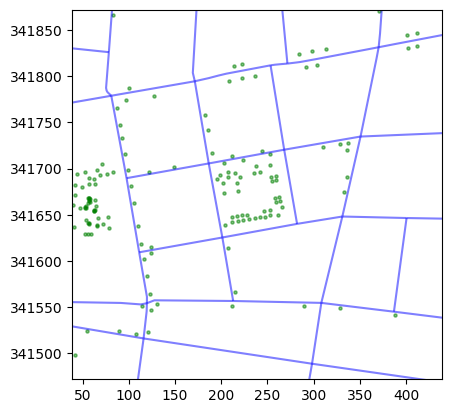

In [1]:
import pandas as pd
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

strassenlinien = pd.read_csv("datasets/strassenlinien.csv")
baeume = pd.read_csv("datasets/baeume.csv")

strassenlinien["geometry"] = strassenlinien["SHAPE"].apply(wkt.loads)
baeume["geometry"] = baeume["SHAPE"].apply(wkt.loads)

strassenlinien = gpd.GeoDataFrame(strassenlinien, geometry="geometry", crs="EPSG:4326")
baeume = gpd.GeoDataFrame(baeume, geometry="geometry", crs="EPSG:4326")

strassenlinien = strassenlinien.to_crs(epsg=31256)
baeume = baeume.to_crs(epsg=31256)

yppen_x, yppen_y = 239, 341672
bbox = box(yppen_x - 200, yppen_y - 200, yppen_x + 200, yppen_y + 200)
_, ax = plt.subplots()
strassenlinien[strassenlinien.intersects(bbox)].plot(ax=ax, color="blue", alpha=0.5, label="Straßenlinien")
baeume[baeume.intersects(bbox)].plot(ax=ax, color="green", alpha=0.5, markersize=5, label="Bäume")
minx, miny, maxx, maxy = bbox.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

Der Baumkataster enthält auch Bäume in Parks oder Innenhöfen.  
Uns interessieren nur Straßenbäume.  
Die definieren wir als jene Bäume die zumindest mit einem Teil ihrer Krone auf die Straße ragen.

Dafür brauchen wir:
* Straßenflächen
* Kronenflächen der einzelnen Bäume

Zunächst die Straßenflächen.  
Leider hat ein Großteil der Straßen im Straßengraphen keine Breite angegeben:

In [2]:
print(f'{len(strassenlinien[strassenlinien["DEDICATEDWIDTH"] == -1])} von {len(strassenlinien)} Straßenlinien ohne Breite!')

18135 von 29568 Straßenlinien ohne Breite!


Die Straßenabschnitte mit vorhandener Breiteninformation sind im Median 10 m breit:

In [3]:
strassenlinien[strassenlinien["DEDICATEDWIDTH"] != -1]["DEDICATEDWIDTH"].median()

np.float64(10.0)

Mit dieser Information Straßenflächen erzeugen:

In [4]:
strassenlinien["buffer_distance"] = strassenlinien["DEDICATEDWIDTH"].apply(lambda width: 5 if width == -1 else width / 2)
strassenflaechen = gpd.GeoDataFrame(geometry=strassenlinien.geometry.buffer(strassenlinien["buffer_distance"], cap_style="flat"), crs=strassenlinien.crs)

Der Kronendurchmesser im Baumkataster ist als Intervall angegeben:

In [5]:
baeume = baeume.rename(columns={"KRONENDURCHMESSER": "KRONENDURCHMESSER_ID"})
baeume.value_counts(subset=['KRONENDURCHMESSER_ID', 'KRONENDURCHMESSER_TXT']).reset_index(name='count')

,KRONENDURCHMESSER_ID,KRONENDURCHMESSER_TXT,count
0,1,0-3 m,70522
1,2,4-6 m,69134
2,3,7-9 m,49752
3,4,10-12 m,22093
4,5,13-15 m,7121
5,0,nicht bekannt,5199
6,6,16-18 m,2038
7,7,19-21 m,622
8,8,>21 m,266
9,4,>21 m,4


Korrigieren der Kronendurchmesser-Texte die nicht zur jeweiligen ID passen.

In [6]:
import numpy as np

baeume["KRONENDURCHMESSER_TXT"] = np.where((baeume["KRONENDURCHMESSER_ID"] == 4) & (baeume["KRONENDURCHMESSER_TXT"] == ">21 m"), "10-12 m", baeume["KRONENDURCHMESSER_TXT"])
baeume["KRONENDURCHMESSER_TXT"] = np.where((baeume["KRONENDURCHMESSER_ID"] == 0) & (baeume["KRONENDURCHMESSER_TXT"] == "0-3 m"), "nicht bekannt", baeume["KRONENDURCHMESSER_TXT"])
baeume["KRONENDURCHMESSER_TXT"] = np.where((baeume["KRONENDURCHMESSER_ID"] == 6) & (baeume["KRONENDURCHMESSER_TXT"] == ">21 m"), "16-18 m", baeume["KRONENDURCHMESSER_TXT"])
baeume["KRONENDURCHMESSER_TXT"] = np.where((baeume["KRONENDURCHMESSER_ID"] == 5) & (baeume["KRONENDURCHMESSER_TXT"] == ">21 m"), "13-15 m", baeume["KRONENDURCHMESSER_TXT"])
baeume["KRONENDURCHMESSER_TXT"] = np.where((baeume["KRONENDURCHMESSER_ID"] == 7) & (baeume["KRONENDURCHMESSER_TXT"] == ">21 m"), "19-21 m", baeume["KRONENDURCHMESSER_TXT"])
baeume["KRONENDURCHMESSER_TXT"] = np.where((baeume["KRONENDURCHMESSER_ID"] == 2) & (baeume["KRONENDURCHMESSER_TXT"] == "7-9 m"), "4-6 m", baeume["KRONENDURCHMESSER_TXT"])

Überprüfung:

In [7]:
baeume.value_counts(subset=['KRONENDURCHMESSER_ID', 'KRONENDURCHMESSER_TXT']).reset_index(name='count')

,KRONENDURCHMESSER_ID,KRONENDURCHMESSER_TXT,count
0,1,0-3 m,70522
1,2,4-6 m,69135
2,3,7-9 m,49752
3,4,10-12 m,22097
4,5,13-15 m,7124
5,0,nicht bekannt,5202
6,6,16-18 m,2041
7,7,19-21 m,625
8,8,>21 m,266


Jetzt konkrete Werte für Kronendurchmesser ermitteln.  
Wir schätzen die Kronendurchmesser auf den Mittelpunkt des jeweiligen Intervalls.

In [8]:
kronendurchmesser_mapping = {
    0: np.nan,
    1: 1.5,
    2: 5,
    3: 8,
    4: 11,
    5: 14,
    6: 17,
    7: 20,
    8: 22
}
baeume["KRONENDURCHMESSER"] = baeume["KRONENDURCHMESSER_ID"].map(kronendurchmesser_mapping)

Mit einem konkreten Wert für den Kronendurchmesser können wir jetzt die Kronenflächen erzeugen und zusammen mit den Straßenflächen visualisieren.  
Für Bäume mit unbekanntem Kronendurchmesser nehmen wir den durchschnittlichen Kronendurchmesser.

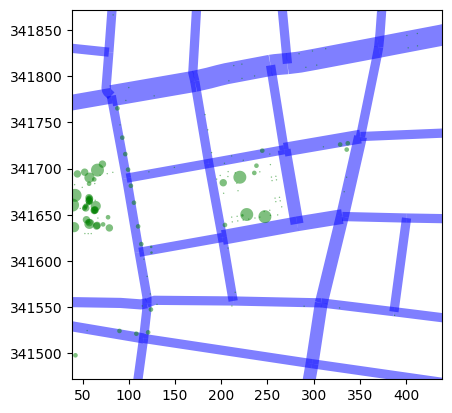

In [9]:
mean_kronendurchmesser = baeume["KRONENDURCHMESSER"].mean()
baeume["kronenflaeche"] = baeume.geometry.buffer(np.where(baeume["KRONENDURCHMESSER"].isna(), mean_kronendurchmesser / 2, baeume["KRONENDURCHMESSER"]) / 2)

bbox = box(yppen_x - 200, yppen_y - 200, yppen_x + 200, yppen_y + 200)
_, ax = plt.subplots()
strassenflaechen[strassenflaechen.intersects(bbox)].plot(ax=ax, color="blue", alpha=0.5, label="Straßenflächen")
baeume[baeume.intersects(bbox)]["kronenflaeche"].plot(ax=ax, color="green", alpha=0.5, label="Kronenflächen der Bäume")
minx, miny, maxx, maxy = bbox.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

Jetzt können wir jene Bäume herausfiltern deren Kronen sich nicht mit den Straßenflächen überschneiden.

100%|██████████| 226764/226764 [00:13<00:00, 16417.09it/s]


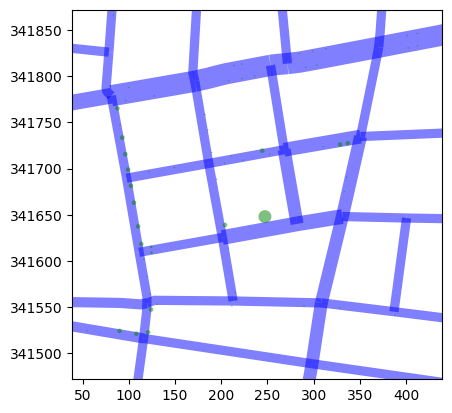

In [10]:
from shapely.prepared import prep
from tqdm import tqdm
from shapely.ops import unary_union

strassenflaechen_merged = unary_union(strassenflaechen.geometry)

tqdm.pandas()
prepared_strassenflaechen = prep(strassenflaechen_merged)
baeume = baeume[baeume["kronenflaeche"].progress_apply(prepared_strassenflaechen.intersects)]

bbox = box(yppen_x - 200, yppen_y - 200, yppen_x + 200, yppen_y + 200)
_, ax = plt.subplots()
strassenflaechen[strassenflaechen.intersects(bbox)].plot(ax=ax, color="blue", alpha=0.5, label="Straßenflächen")
baeume[baeume.intersects(bbox)]["kronenflaeche"].plot(ax=ax, color="green", alpha=0.5, label="Kronenflächen der Bäume")
minx, miny, maxx, maxy = bbox.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

Einige der Baumkatastereinträge beschreiben keine echten Bäume sondern noch zu pflanzende Jungbäume.  

In [11]:
len(baeume[baeume["GATTUNG_ART"] == "Jungbaum wird gepflanzt"])

1972

Diese auch entfernen.

In [12]:
baeume = baeume[baeume["GATTUNG_ART"] != "Jungbaum wird gepflanzt"]

Wie viele Bäume bleiben übrig von den ursprünglichen?

In [13]:
print(f"{len(baeume)} vs {len(pd.read_csv('datasets/baeume.csv'))}")

91178 vs 226764


Die Metriken im Baumkataster sind teils etwas unintuitiv, deshalb:
* Pflanzjahr -> Alter
* Stammumfang -> Stammdurchmesser

In [14]:
from datetime import datetime

current_year = datetime.now().year
baeume["ALTER"] = np.where(baeume["PFLANZJAHR"] > 0, current_year - baeume["PFLANZJAHR"], np.nan)
baeume["ALTER_TXT"] = np.where(baeume["ALTER"] >= 0, baeume["ALTER"].astype("Int64").astype(str) + " Jahre", "unbekannt")

baeume["STAMMDURCHMESSER"] = np.where(baeume["STAMMUMFANG"] > 0, baeume["STAMMUMFANG"] / np.pi, np.nan)
baeume["STAMMDURCHMESSER_TXT"] = np.where(baeume["STAMMDURCHMESSER"].isna(), "unbekannt", baeume["STAMMDURCHMESSER"].round().astype("Int64").astype(str) + " cm")

Auch bei Kronendurchmesser und Baumhöhe fehlende Werte auf `np.nan` bzw. `unbekannt` setzen.

In [15]:
baeume.value_counts(subset=['BAUMHOEHE', 'BAUMHOEHE_TXT']).reset_index(name='count')

,BAUMHOEHE,BAUMHOEHE_TXT,count
0,2,6-10 m,33667
1,1,0-5 m,25146
2,3,11-15 m,23806
3,4,16-20 m,6504
4,5,21-25 m,1232
5,0,nicht bekannt,539
6,6,26-30 m,266
7,7,31-35 m,14
8,8,> 35 m,4


In [16]:
baeume["KRONENDURCHMESSER_TXT"] = np.where(baeume["KRONENDURCHMESSER_ID"] == 0, "unbekannt", baeume["KRONENDURCHMESSER_TXT"])
baeume["KRONENDURCHMESSER_ID"] = np.where(baeume["KRONENDURCHMESSER_ID"] == 0, np.nan, baeume["KRONENDURCHMESSER_ID"])

baeume = baeume.rename(columns={"BAUMHOEHE": "BAUMHOEHE_ID"})
baeume["BAUMHOEHE_TXT"] = np.where(baeume["BAUMHOEHE_ID"] == 0, "unbekannt", baeume["BAUMHOEHE_TXT"])
baeume["BAUMHOEHE_ID"] = np.where(baeume["BAUMHOEHE_ID"] == 0, np.nan, baeume["BAUMHOEHE_ID"])

Für jede Metrik eines Baumes möchten wir wissen in welchem Perzentil die jeweilige Metrikausprägung liegt.  
Unbekannte Werte ignorieren wir.  
Für Baumhöhe und Kronendurchmesser die in Intervallen angegeben sind verwenden wir einfach die (aufsteigende) Intervall-ID.

In [17]:
baeume["ALTER_PERCENTILE"] = np.clip((baeume["ALTER"].rank(pct=True, na_option="keep") * 100).round(0).astype("Int64"), 1, 99)
baeume["BAUMHOEHE_PERCENTILE"] = np.clip((baeume["BAUMHOEHE_ID"].rank(pct=True, na_option="keep") * 100).round(0).astype("Int64"), 1, 99)
baeume["STAMMDURCHMESSER_PERCENTILE"] = np.clip((baeume["STAMMDURCHMESSER"].rank(pct=True, na_option="keep") * 100).round(0).astype("Int64"), 1, 99)
baeume["KRONENDURCHMESSER_PERCENTILE"] = np.clip((baeume["KRONENDURCHMESSER_ID"].rank(pct=True, na_option="keep") * 100).round(0).astype("Int64"), 1, 99)

Für Gattung und Art eines Baumes bewerten wir die Seltenheit.  
Wie viele Gattungen bzw. Arten gibt es eigentlich?

In [18]:
len(baeume["GATTUNG_ART"].unique())

426

Ziemlich viele!  
Die Seltenheit wäre für viele Gattungen mit Art also sehr hoch.  
Bei vielen Bäumen ist noch die Sorte angegeben, vielleicht gibt es auch deswegen so viele verschiedene Ausprägungen.  
Hinter dem lateinischen Namen steht in Klammer die deutsche Bezeichnung ohne Sorte, z.B. _Cercis canadensis 'Ruby Falls' (Kanadischer Judasbaum)_  
Haben alle Bäume so eine deutsche Bezeichnung?

In [19]:
has_german_name = baeume["GATTUNG_ART"].str.contains(r"\(.*\)", na=False)
missing_german_name = baeume[~has_german_name]
print(missing_german_name["GATTUNG_ART"])

10839     nicht bekannt
14047     nicht bekannt
40577     nicht bekannt
42389     nicht bekannt
57461     nicht bekannt
111460    nicht bekannt
133427    nicht bekannt
134162    nicht bekannt
141606    nicht bekannt
159625    nicht bekannt
Name: GATTUNG_ART, dtype: object


Passt, also wie viele einzigartige deutsche Artbezeichnungen gibt es?

In [20]:
baeume["GATTUNG_ART_DEUTSCH"] = baeume["GATTUNG_ART"].str.extract(r"\((.*?)\)")
len(baeume["GATTUNG_ART_DEUTSCH"].unique())

357

Nicht berauschend aber besser!  
Jetzt die Verteilung.

In [21]:
baeume["GATTUNG_ART"] = baeume["GATTUNG_ART_DEUTSCH"]
baeume["GATTUNG_ART"].value_counts()

GATTUNG_ART
Spitzahorn                8735
Rosskastanie              6220
Südlicher Zürgelbaum      5065
Ahornblättrige Platane    4388
Winterlinde               4302
                          ... 
Säulenschwarzkiefer          1
Winterlinde 'Wega'           1
Blutbuche                    1
Glänzender Kreuzdorn         1
Grauerle                     1
Name: count, Length: 356, dtype: int64

In [22]:
baeume["GATTUNG_ART_FREQUENCY"] = baeume["GATTUNG_ART"].map(baeume["GATTUNG_ART"].value_counts())

Schließlich exportieren wir die Bäume mit ihren darzustellenden Eigenschaften als GeoJSON.

In [23]:
baeume_wsg84 = baeume[["geometry", "BAUMNUMMER", "GATTUNG_ART", "GATTUNG_ART_FREQUENCY", "ALTER_TXT", "ALTER_PERCENTILE", "STAMMDURCHMESSER_TXT", "STAMMDURCHMESSER_PERCENTILE", "BAUMHOEHE_TXT", "BAUMHOEHE_PERCENTILE", "KRONENDURCHMESSER", "KRONENDURCHMESSER_TXT", "KRONENDURCHMESSER_PERCENTILE"]].to_crs(epsg=4326)
baeume_wsg84.to_file("web/baeume.geojson", driver="GeoJSON", id_generate=True)

Um die Wiener Straßenflächen je nach Baumdichte einzufärben visualisieren wir die Bäume als Heatmap und maskieren diese mit den invertierten Straßenflächen.  
Die invertierten Straßenflächen padden wir mir je 3 km in jede Richtung um die interaktive Karte besser navigierbar zu machen.

In [24]:
from shapely.geometry import box

minx, miny, maxx, maxy = baeume.total_bounds
bounding_box = box(minx - 3000, miny - 3000, maxx + 3000, maxy + 3000)
inverted_strassenflaechen = bounding_box.difference(strassenflaechen_merged)

inverted_strassenflaechen = gpd.GeoDataFrame(geometry=[inverted_strassenflaechen], crs="EPSG:31256")
inverted_strassenflaechen.to_crs(epsg=4326).to_file("web/inverted_strassenflaechen.geojson", driver="GeoJSON")

Welche Max-Bounds für die Visualisierung setzen?

In [25]:
inverted_strassenflaechen.to_crs(epsg=4326).total_bounds

array([16.15990817, 48.09620512, 16.58841854, 48.34667157])